# SNOWPACK demonstration figure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from Load_and_Process_Datasets import *
from palettable.colorbrewer.sequential import *
from pandas.plotting import register_matplotlib_converters
import geopandas as gpd
import cartopy.crs as ccrs
register_matplotlib_converters()

# Misc. Operations for plots

In [2]:
# Time range
# year_start = "2000"
# year_end = "2010"
year_start = "2010"
year_end = "2015"
t0 = pd.to_datetime(year_start + '0101', format='%Y%m%d')
tf = pd.to_datetime(year_end + '0101', format='%Y%m%d')

# Site lat/lon
lat = [-90, -79.466]
lon = [0, -112.0833]

# Depth thresh
depth_thresh = 1
depth_thresh_str = str(int(depth_thresh * 100))

# Define paths

In [3]:
# paths to SNOWPACK output files
WAIS_pro =  "/pl/active/nasa_smb/simulations/up_to_date_simulations/density_profile_10mfl_ov_rr/density_profile_32/output/LAT-79.3831LON-111.239.pro"
WAIS_smet = "/pl/active/nasa_smb/simulations/up_to_date_simulations/density_profile_10mfl_ov_rr/density_profile_32/output/LAT-79.3831LON-111.239.smet"
SP_pro = "/pl/active/nasa_smb/simulations/up_to_date_simulations/density_profile_10mfl_ov_rr/density_profile_1/output/LAT-89.9333LON144.3938.pro"
SP_smet = "/pl/active/nasa_smb/simulations/up_to_date_simulations/density_profile_10mfl_ov_rr/density_profile_1/output/LAT-89.9333LON144.3938.smet"

# Retrieve data

In [4]:
# Surface temperature
WAIS_ts = snwpck_1D.get_smet_timeseries(WAIS_smet, "TSS_mod")
SP_ts = snwpck_1D.get_smet_timeseries(SP_smet, "TSS_mod")

# Near surface density
!bash extract_timeseries.sh {WAIS_pro} {depth_thresh} > WAIS_nsd.txt
WAIS_nsd = np.loadtxt("WAIS_nsd.txt", usecols=(3))
WAIS_gs = np.loadtxt("WAIS_nsd.txt", usecols=(4))
time = np.loadtxt("WAIS_nsd.txt", usecols = 0, dtype = 'str') 
time = pd.to_datetime(time, format = '%Y-%m-%dT%H:%M:%S')
WAIS_nsd = pd.DataFrame(WAIS_nsd, index = time)
WAIS_gs = pd.DataFrame(WAIS_gs, index = time)

!bash extract_timeseries.sh {SP_pro} {depth_thresh} > SP_nsd.txt
SP_nsd = np.loadtxt("SP_nsd.txt", usecols=(3))
SP_gs = np.loadtxt("SP_nsd.txt", usecols=(4))
time = np.loadtxt("SP_nsd.txt", usecols = 0, dtype = 'str') 
time = pd.to_datetime(time, format = '%Y-%m-%dT%H:%M:%S')
SP_nsd = pd.DataFrame(SP_nsd, index = time)
SP_gs = pd.DataFrame(SP_gs, index = time)

# Winter depth profiles
winter_date = year_start + "0621"
winter_date = str(pd.to_datetime(winter_date, format='%Y%m%d'))
!bash postprocess.sh {WAIS_pro} {winter_date} > WAIS_pro_data.txt
WAIS_winter_depth, WAIS_winter_density = np.loadtxt("WAIS_pro_data.txt", usecols=(2, 5), unpack=True)
!bash postprocess.sh {SP_pro} {winter_date} > SP_pro_data.txt
SP_winter_depth, SP_winter_density = np.loadtxt("SP_pro_data.txt", usecols=(2, 5), unpack=True)

# Winter temperature profiles
WAIS_winter_depth, WAIS_winter_temp = np.loadtxt("WAIS_pro_data.txt", usecols=(2, 4), unpack=True)
SP_winter_depth, SP_winter_temp = np.loadtxt("SP_pro_data.txt", usecols=(2, 4), unpack=True)

# # Summer depth profiles
# summer_date = year_start + "1221"
# summer_date = str(pd.to_datetime(summer_date, format='%Y%m%d'))
# !bash postprocess.sh {WAIS_pro} {summer_date} > WAIS_pro_data.txt
# WAIS_summer_depth, WAIS_summer_density = np.loadtxt("WAIS_pro_data.txt", usecols=(2, 5), unpack=True)
# !bash postprocess.sh {SP_pro} {summer_date} > SP_pro_data.txt
# SP_summer_depth, SP_summer_density = np.loadtxt("SP_pro_data.txt", usecols=(2, 5), unpack=True)

In [5]:
# Winter temperature profiles
WAIS_winter_depth, WAIS_winter_temp = np.loadtxt("WAIS_pro_data.txt", usecols=(2, 4), unpack=True)
SP_winter_depth, SP_winter_temp = np.loadtxt("SP_pro_data.txt", usecols=(2, 4), unpack=True)

# Map of sites

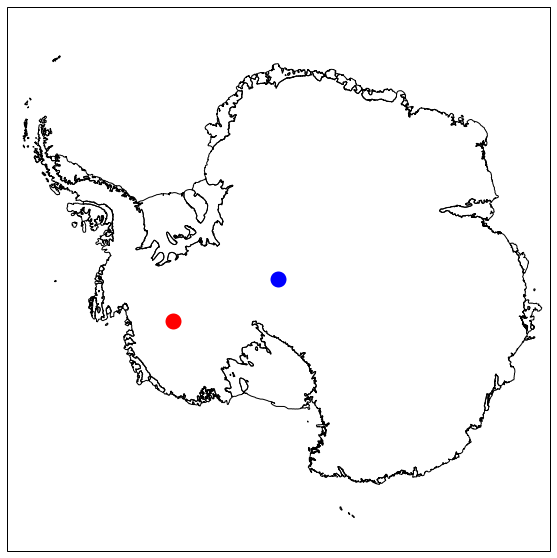

In [6]:
# Coastline Data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot SNOWPACK minus Observations
plt.scatter(lon[0], lat[0], linewidth=10, c='b', marker='o', label='South Pole', transform=ccrs.Geodetic())
plt.scatter(lon[1], lat[1], linewidth=10, c='r', marker='o', label='WAIS Divide', transform=ccrs.Geodetic())
# plt.legend()
plt.savefig("Figures/demo_map.pdf", format='pdf', dpi=100)

# Plot surface temperature timeseries

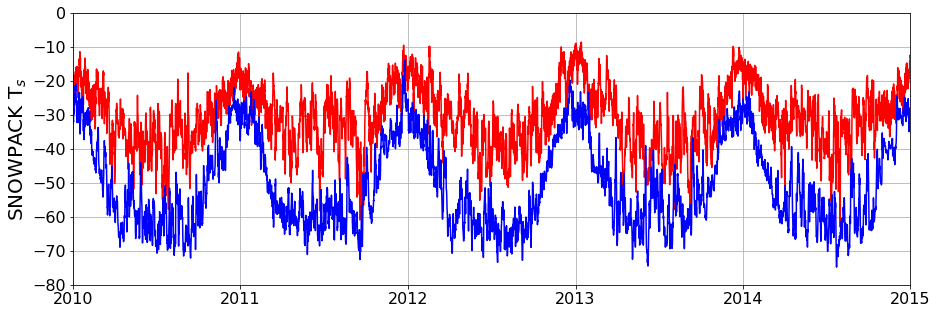

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(WAIS_ts, 'r', label='WAIS Divide')
plt.plot(SP_ts, 'b', label='South Pole')
plt.xlim([t0, tf])
plt.ylim([-80, 0])
plt.ylabel("SNOWPACK T$_{s}$", fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
# plt.legend()
plt.savefig("Figures/demo_ts.pdf", format='pdf', dpi=100)

# Plot near surface density timeseries

0    125.078926
dtype: float64
0    1.107045
dtype: float64
0    1.160485
dtype: float64


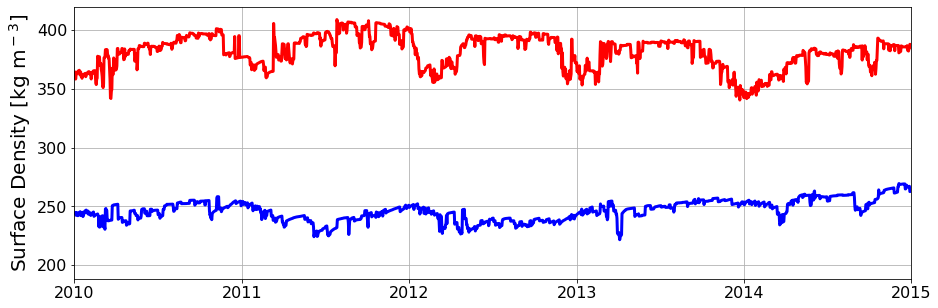

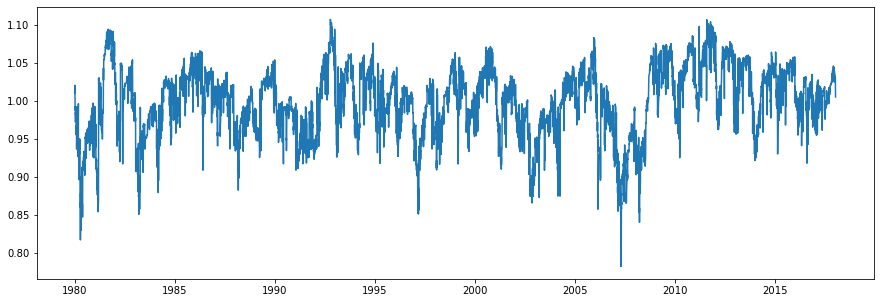

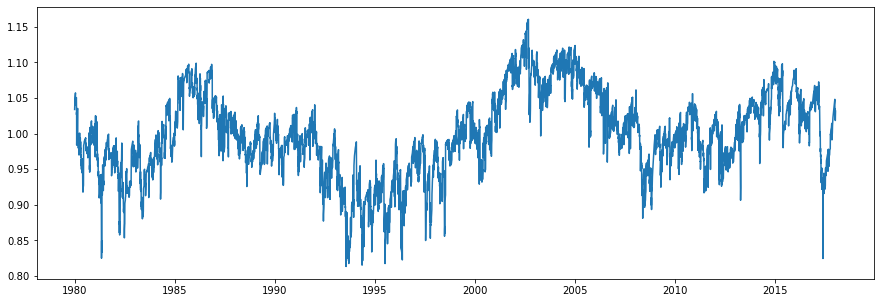

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(WAIS_nsd, 'r', linewidth=3, label='WAIS Divide')
plt.plot(SP_nsd, 'b', linewidth=3, label='South Pole')
plt.xlim([t0, tf])
plt.ylabel("Surface Density [kg m$^-$$^3$]", fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
# plt.legend()
plt.savefig("Figures/demo_rho.pdf", format='pdf', dpi=100)

# Stats
print(WAIS_nsd.mean() - SP_nsd.mean())

plt.figure(figsize=(15, 5))
plt.plot(WAIS_nsd / WAIS_nsd.mean())
print(np.abs(WAIS_nsd / WAIS_nsd.mean()).max())

plt.figure(figsize=(15, 5))
plt.plot(SP_nsd / SP_nsd.mean())
print(np.abs(SP_nsd / SP_nsd.mean()).max())

# Plot near surface grain size timeseries

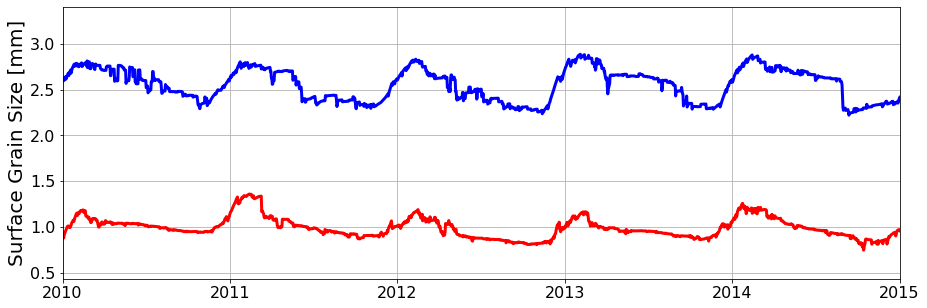

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(WAIS_gs, 'r', linewidth=3, label='WAIS Divide')
plt.plot(SP_gs, 'b', linewidth=3, label='South Pole')
plt.xlim([t0, tf])
plt.ylabel("Surface Grain Size [mm]", fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
# plt.legend()
plt.savefig("Figures/demo_gs.pdf", format='pdf', dpi=100)

# Stats


# Plot winter density profiles

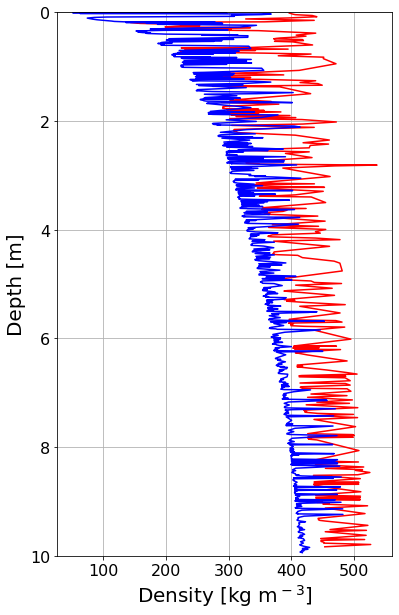

In [10]:
plt.figure(figsize=(6, 10))
plt.plot(WAIS_winter_density, WAIS_winter_depth, 'r', label='WAIS Divide')
# plt.plot(WAIS_summer_density, WAIS_summer_depth, 'r--')
plt.plot(SP_winter_density, SP_winter_depth, 'b', label='South Pole')
# plt.plot(SP_summer_density, SP_summer_depth, 'b--')
plt.ylim([0, 10])
plt.gca().invert_yaxis()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
# plt.legend()
plt.ylabel("Depth [m]", fontsize = 20)
plt.xlabel("Density [kg m$^-$$^3$]", fontsize = 20)
plt.savefig("Figures/demo_rho_profile.pdf", format='pdf', dpi=100)

# Plot winter temperature profiles

18.321844451884687

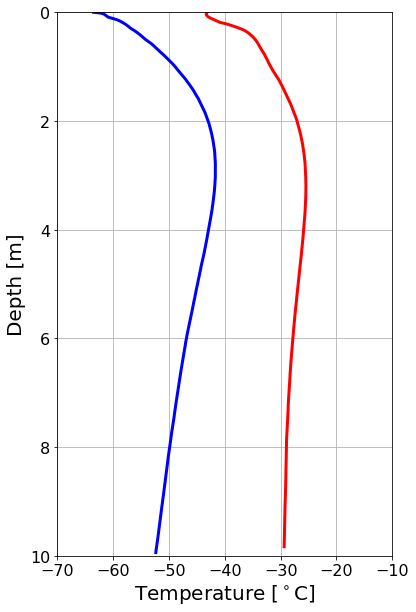

In [27]:
plt.figure(figsize=(6, 10))
plt.plot(WAIS_winter_temp - 273.15, WAIS_winter_depth, 'r', linewidth=3, label='WAIS Divide')
# plt.plot(WAIS_summer_density, WAIS_summer_depth, 'r--')
plt.plot(SP_winter_temp -273.15, SP_winter_depth, 'b', linewidth=3, label='South Pole')
# plt.plot(SP_summer_density, SP_summer_depth, 'b--')
plt.ylim([0, 10])
plt.gca().invert_yaxis()
plt.xticks([-70, -60, -50, -40, -30, -20, -10], fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
# plt.legend()
plt.ylabel("Depth [m]", fontsize = 20)
plt.xlabel("Temperature [$^\circ$C]", fontsize = 20)
plt.savefig("Figures/demo_temperature_profile.pdf", format='pdf', dpi=100)

WAIS_winter_temp.mean() - SP_winter_temp.mean()